# CACD: InceptionV3

In [2]:
import keras
import os, shutil
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
%matplotlib inline

train_dir = 'data\\imdb\\train'
test_dir = 'data\\imdb\\test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=32
)

Found 221477 images belonging to 62 classes.
Found 15843 images belonging to 62 classes.


# Defining custom metrix

In [3]:
def five_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 5,
                  K.floatx())

def ten_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 10,
                  K.floatx())


In [4]:
from keras.applications.inception_v3 import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
                 
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_4 (Dense)              (None, 62)                31806     
Total params: 31,272,286
Trainable params: 9,469,502
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=2275, 
                              epochs=1, 
                              validation_data=test_generator,
                              validation_steps=250)

This is the number of trainable weights before freezing the conv base: 4
Epoch 1/1
2275/2275 [==============================] - 133s 58ms/step - loss: 3.9115 - categorical_accuracy: 0.0352 - five_claas_diff: 0.3492 - ten_claas_diff: 0.6074 - val_loss: 4.1883 - val_categorical_accuracy: 0.0331 - val_five_claas_diff: 0.3411 - val_ten_claas_diff: 0.5952


In [9]:
from keras.models import load_model
try:
    model = load_model('checkpoints\\cacd_inception.h5', custom_objects={'five_claas_diff': five_claas_diff, 'ten_claas_diff':ten_claas_diff})
except:
    pass

# Fine tuning

In [10]:
conv_base.trainable = True

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=2275, 
                              epochs=30, 
                              validation_data=test_generator, 
                              callbacks=[
                                  keras.callbacks.ModelCheckpoint('checkpoints\\cacd_inception.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
                              ],
                              validation_steps=250)

Epoch 1/30
2275/2275 [==============================] - 410s 180ms/step - loss: 3.7517 - categorical_accuracy: 0.0432 - five_claas_diff: 0.4137 - ten_claas_diff: 0.6857 - val_loss: 4.1126 - val_categorical_accuracy: 0.0475 - val_five_claas_diff: 0.4418 - val_ten_claas_diff: 0.7150
Epoch 2/30
2275/2275 [==============================] - 396s 174ms/step - loss: 3.6574 - categorical_accuracy: 0.0485 - five_claas_diff: 0.4637 - ten_claas_diff: 0.7318 - val_loss: 3.7065 - val_categorical_accuracy: 0.0499 - val_five_claas_diff: 0.4798 - val_ten_claas_diff: 0.7506
Epoch 3/30
2275/2275 [==============================] - 395s 174ms/step - loss: 3.6179 - categorical_accuracy: 0.0525 - five_claas_diff: 0.4841 - ten_claas_diff: 0.7485 - val_loss: 3.6724 - val_categorical_accuracy: 0.0553 - val_five_claas_diff: 0.4868 - val_ten_claas_diff: 0.7476
Epoch 4/30
2275/2275 [==============================] - 396s 174ms/step - loss: 3.5643 - categorical_accuracy: 0.0584 - five_claas_diff: 0.5090 - ten_claa

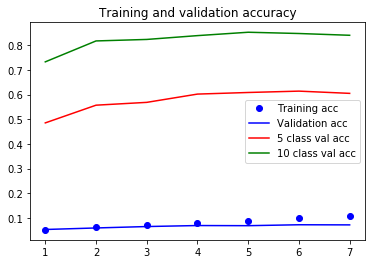

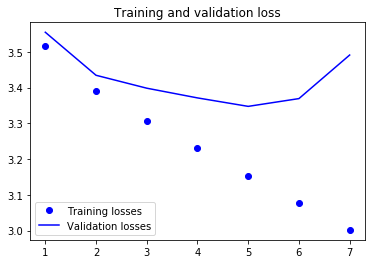

In [10]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()